In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

TRAIN_DATA_DIR = "~/projects/kaggleComp/data/train.csv"
TEST_DATA_DIR = "~/projects/kaggleComp/data/test.csv"

train = pd.read_csv(TRAIN_DATA_DIR)
test = pd.read_csv(TEST_DATA_DIR)

df = pd.concat([train, test], axis=0)

In [4]:
df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [5]:
df.describe()

,id,Compartments,Weight Capacity (kg),Price
count,500000.000000,500000.000000,499785.000000,300000.000000
mean,249999.500000,5.443296,18.015209,81.411107
std,144337.711635,2.889952,6.968997,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,124999.750000,3.000000,12.086395,47.384620
50%,249999.500000,5.000000,18.064996,80.956120
75%,374999.250000,8.000000,23.985510,115.018160
max,499999.000000,10.000000,30.000000,150.000000


In [6]:
df.describe(include=['object'])

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,484068,486040,489024,487594,488139,486877,483265
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,100250,132657,169681,247001,246671,166418,86451


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    500000 non-null  int64  
 1   Brand                 484068 non-null  object 
 2   Material              486040 non-null  object 
 3   Size                  489024 non-null  object 
 4   Compartments          500000 non-null  float64
 5   Laptop Compartment    487594 non-null  object 
 6   Waterproof            488139 non-null  object 
 7   Style                 486877 non-null  object 
 8   Color                 483265 non-null  object 
 9   Weight Capacity (kg)  499785 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 45.8+ MB


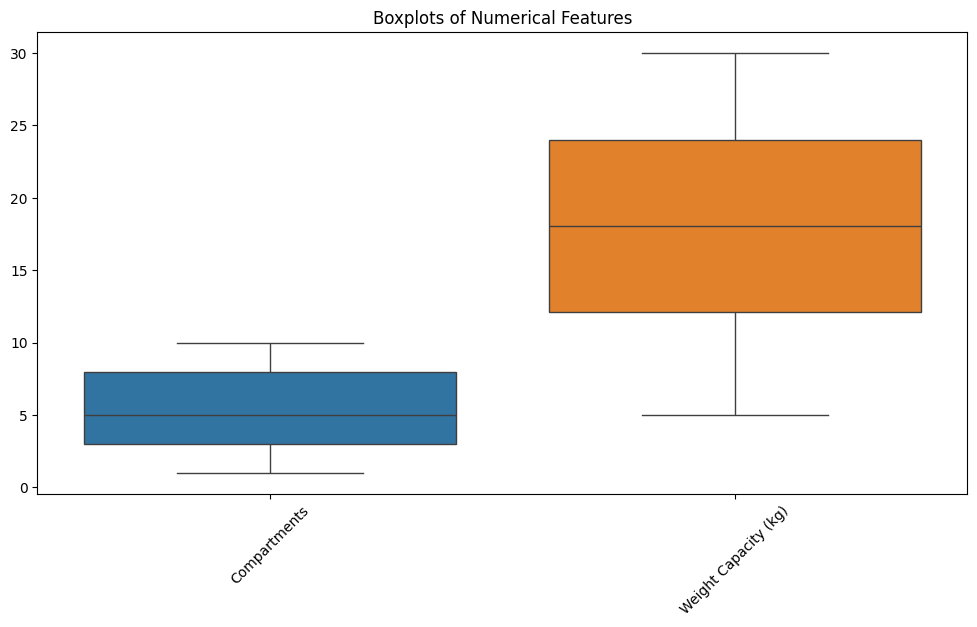

In [21]:
numerical_features = list(df.select_dtypes(['float64']).columns)[:-1]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_features])
plt.xticks(rotation=45)
plt.title('Boxplots of Numerical Features')
plt.show()

<Axes: xlabel='Compartments', ylabel='Count'>

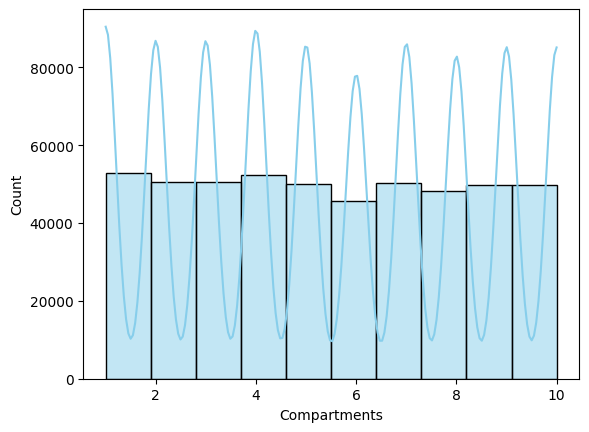

In [36]:
sns.histplot(df['Compartments'], bins=10, kde=True, color='skyblue', edgecolor='black')

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

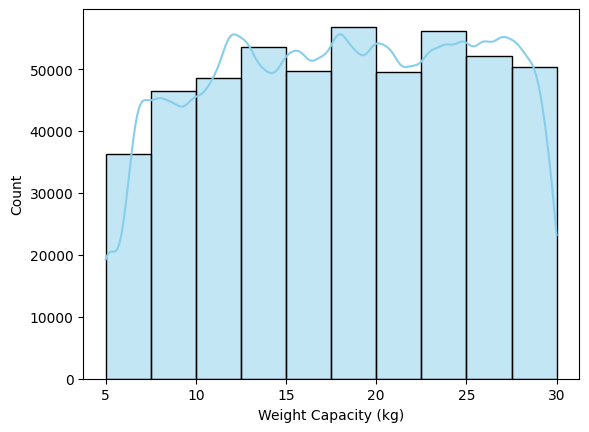

In [34]:
sns.histplot(df['Weight Capacity (kg)'], bins=10, kde=True, color='skyblue', edgecolor='black')

## Data Pipeline

- Fill Categorical Features with the mode
- Fill float features with the mean
- Scale float features

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder


class Dropper(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.features, errors="ignore") 

class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="mean", features=None):
        self.strategy = strategy
        self.features = features
        self.imputer = SimpleImputer(strategy=self.strategy)
    
    def fit(self, X, y=None):
        self.imputer.fit(X[self.features])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.features] = self.imputer.transform(X_copy[self.features])
        return X_copy

class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, kind="ordinal", features=None):
        self.kind = kind
        self.features = features
        self.encoder = None

    def fit(self, X, y=None):
        if self.kind == "ordinal":
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        elif self.kind == "nominal":
            self.encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.encoder.fit(X[self.features])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        transformed = self.encoder.transform(X_copy[self.features])
        
        if self.kind == "nominal":
            transformed = pd.DataFrame(transformed, columns=self.encoder.get_feature_names_out(self.features))
            X_copy = X_copy.drop(columns=self.features).reset_index(drop=True)
            X_copy = pd.concat([X_copy, transformed], axis=1)
        else:
            X_copy[self.features] = transformed
            
        return X_copy

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.features])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.features] = self.scaler.transform(X_copy[self.features])
        return X_copy


In [51]:
from sklearn.pipeline import Pipeline

categorical_features = list(df.select_dtypes(include=['object']))
numerical_features = list(df.select_dtypes(include=['float64']))[:-1]

pipeline = Pipeline([
    ('dropper', Dropper(features=['id'])),
    ('categorical_imputer', Imputer(strategy="most_frequent", features=categorical_features)),
    ('numerical_imputer', Imputer(strategy="mean", features=numerical_features)),
    ('ordinal_encoder', Encoder(kind='ordinal', features=['Laptop Compartment', 'Waterproof', 'Size'])),
    ('nominal_encoder', Encoder(kind='nominal', features=['Brand', 'Material', 'Style', 'Color'])),
    ('scaling', Scaler(features=numerical_features))
])

df_transformed = pipeline.fit_transform(df)


In [52]:
df_transformed

,Size,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Price,Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,...,Material_Polyester,Style_Backpack,Style_Messenger,Style_Tote,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,1.0,0.666667,1.0,0.0,0.264469,112.15875,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.000000,1.0,1.0,0.883141,68.88056,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,0.111111,1.0,0.0,0.465750,39.17320,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.0,0.777778,1.0,0.0,0.317489,80.60793,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.000000,1.0,1.0,0.509974,86.02312,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.0,0.111111,1.0,0.0,0.095340,NaN,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
499996,2.0,0.888889,0.0,1.0,0.042336,NaN,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
499997,2.0,0.888889,0.0,1.0,0.875607,NaN,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
499998,0.0,1.000000,1.0,0.0,0.830766,NaN,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Size                  500000 non-null  float64
 1   Compartments          500000 non-null  float64
 2   Laptop Compartment    500000 non-null  float64
 3   Waterproof            500000 non-null  float64
 4   Weight Capacity (kg)  500000 non-null  float64
 5   Price                 300000 non-null  float64
 6   Brand_Adidas          500000 non-null  float64
 7   Brand_Jansport        500000 non-null  float64
 8   Brand_Nike            500000 non-null  float64
 9   Brand_Puma            500000 non-null  float64
 10  Brand_Under Armour    500000 non-null  float64
 11  Material_Canvas       500000 non-null  float64
 12  Material_Leather      500000 non-null  float64
 13  Material_Nylon        500000 non-null  float64
 14  Material_Polyester    500000 non-null  float64
 15  